In [32]:
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt

import lina
from lina import psds

fmax = 100*u.Hz
freqs, delF = psds.generate_freqs(Nf=2**18+1, f_max=fmax)


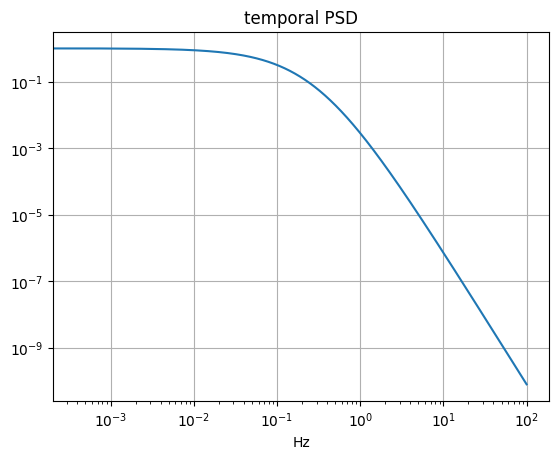

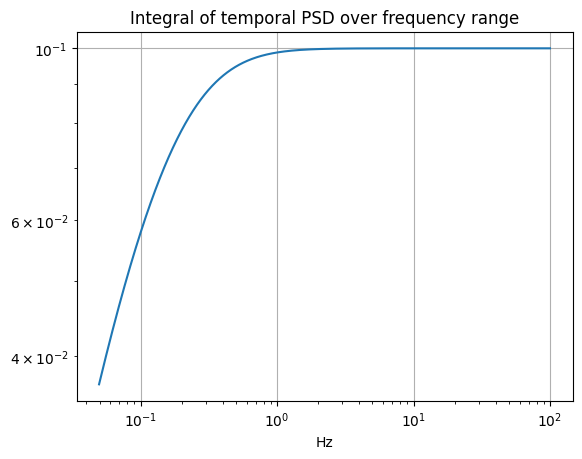

262145 524288
7240.773439350246 1.3613550118266145e-12
262145 524288
14481.546878700494 2.7249835925977707e-12


In [26]:
f_knee = 0.3*u.Hz
psd = psds.kneePSD(freqs, 1, f_knee, 4)

psds.plot(freqs, psd, plot_integral=True)

tip, times = psds.generate_time_series(psd, fmax, rms=10, seed=123)
tilt, _ = psds.generate_time_series(psd, fmax, rms=20, seed=1234)

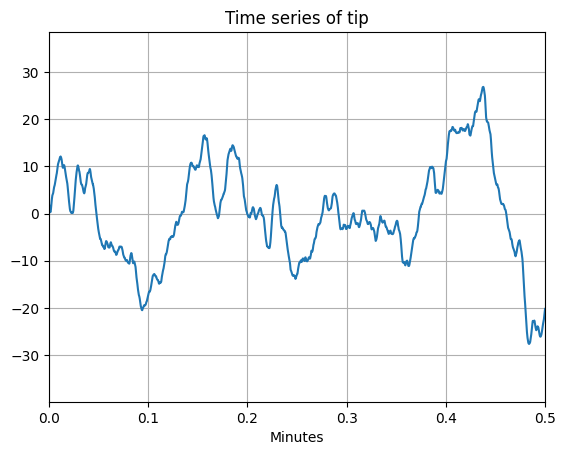

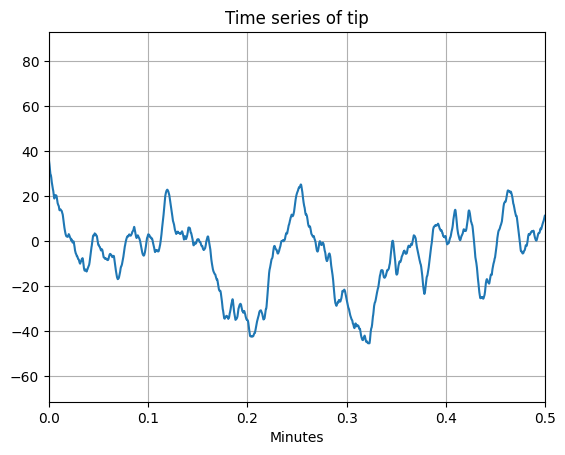

In [27]:
plt.plot(times/60, tip)
plt.title('Time series of tip')
plt.grid()
plt.xlim([0,0.5])
plt.xlabel('Minutes')
plt.show()

plt.plot(times/60, tilt)
plt.title('Time series of tip')
plt.grid()
plt.xlim([0,0.5])
plt.xlabel('Minutes')
plt.show()


In [29]:
np.sqrt(np.mean(np.square((tip)))), np.sqrt(np.mean(np.square((tilt))))

(10.0, 20.0)

In [30]:
pointing_error_series = np.concatenate([[times],[tip],[tilt]])
pointing_error_series.shape

(3, 524288)

In [31]:
lina.utils.save_fits('pointing_error_time_series.fits', pointing_error_series)

Saved data to:  pointing_error_time_series.fits
